In [1]:
#imports
def imports():
    None

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

from wrangle import acquire_wine, wine_train_val_test, wrangle_wine, model_pipeline
from vis import quality_distribution, alcohol_distribution, alcohol_vs_quanity

#set display peferences
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)

In [2]:
train, val, test = wrangle_wine()

In [3]:
train.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,type
3761,9.9,0.490,0.23,2.4,0.087,19.0,115.0,0.99480,2.77,0.44,9.400000,6,white
3740,7.7,0.280,0.35,15.3,0.056,31.0,117.0,0.99980,3.27,0.50,9.600000,5,white
1359,11.6,0.475,0.40,1.4,0.091,6.0,28.0,0.99704,3.07,0.65,10.033333,6,red
1230,7.7,0.180,0.34,2.7,0.066,15.0,58.0,0.99470,3.37,0.78,11.800000,6,red
4751,7.6,0.250,1.23,4.6,0.035,51.0,294.0,0.99018,3.03,0.43,13.100000,6,white


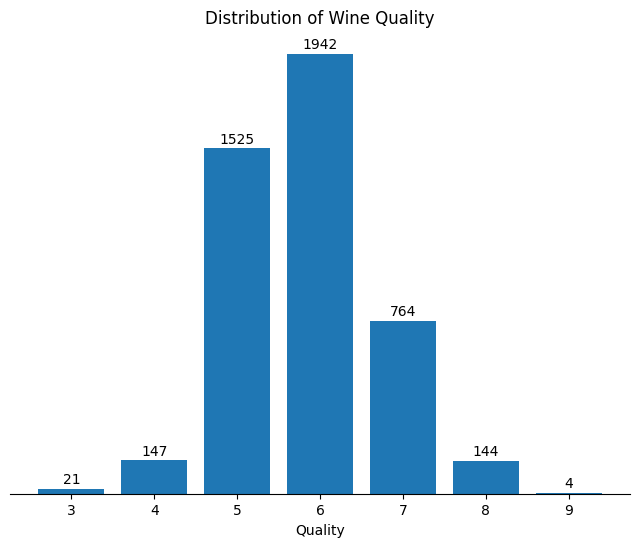

In [4]:
quality_distribution(train)

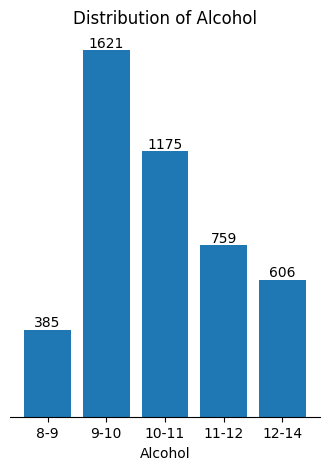

In [5]:
alcohol_distribution(train)

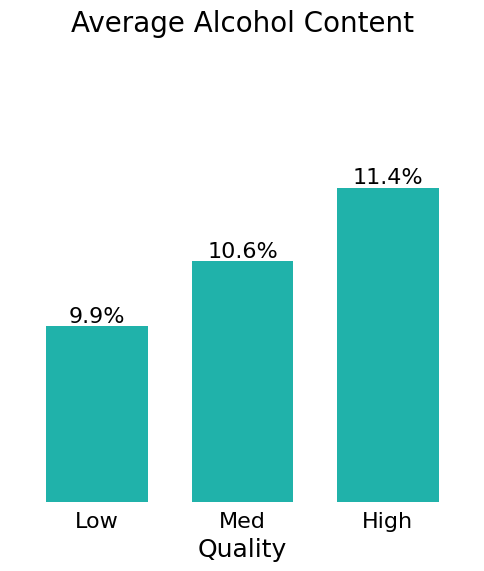

In [6]:
alcohol_vs_quanity(train)